In [1]:
%matplotlib inline

import sys
sys.path.append("..")

from src.regime_trading_pipeline import RegimeRotationStrategy
from src.performance_toolkit import RegimePerformanceToolkit

## Fit WK-means Model and Build Returns

In [ ]:
growth = [
    "EFG",   # iShares MSCI EAFE Growth ETF
    "IWF",   # iShares Russell 1000 Growth ETF
    "IWP",   # iShares Russell Mid-Cap Growth ETF
    "IWY",   # iShares Russell Top 200 Growth ETF
    "QUAL",  # iShares MSCI USA Quality Factor ETF
    "QQQ",   # Invesco QQQ Trust (Nasdaq-100)
    "RPG",   # Invesco S&P 500 Pure Growth ETF
    "SCHG",  # Schwab U.S. Large-Cap Growth ETF
    "SCHM",  # Schwab U.S. Mid-Cap ETF
    "SLYG",  # SPDR S&P 600 Small Cap Growth ETF
    "SPYG",  # SPDR Portfolio S&P 500 Growth ETF
    "VBK",   # Vanguard Small-Cap Growth ETF
    "VGT",   # Vanguard Information Technology Index Fund ETF
    "VUG",   # Vanguard Growth ETF
]

# Retrieved from https://www.simplysafedividends.com/world-of-dividends/posts/939-20-best-recession-proof-dividend-stocks-for-a-2025-downturn
defensive = [
    "BMY",  # Bristol-Myers Squibb Co. (pharmaceuticals)
    "CL",   # Colgate-Palmolive Co. (consumer staples – personal care)
    "CVX",  # Chevron Corp. (integrated oil & gas)
    "DUK",  # Duke Energy Corp. (regulated electric utility)
    "ED",   # Consolidated Edison, Inc. (regulated utility)
    "EPD",  # Enterprise Products Partners L.P. (midstream energy MLP)
    "GIS",  # General Mills, Inc. (packaged foods)
    "GPC",  # Genuine Parts Co. (industrial/auto parts distributor)
    "JNJ",  # Johnson & Johnson (healthcare & consumer health)
    "KMB",  # Kimberly-Clark Corp. (tissue & hygiene products)
    "KO",   # Coca-Cola Co. (beverages)
    "LMT",  # Lockheed Martin Corp. (defense & aerospace)
    "MCD",  # McDonald's Corp. (global quick-service restaurants)
    "O",    # Realty Income Corp. (net-lease REIT, “monthly dividend”)
    "PEP",  # PepsiCo, Inc. (snacks & beverages)
    "PG",   # Procter & Gamble Co. (household & personal products)
    "PSA",  # Public Storage (self-storage REIT)
    "VZ",   # Verizon Communications Inc. (telecom)
    "WEC",  # WEC Energy Group, Inc. (regulated utility)
    "XOM",  # Exxon Mobil Corp. (integrated oil & gas)
]

strategy = RegimeRotationStrategy(
    growth_tickers=growth,
    defensive_tickers=defensive,
    start_date="2019-05-09",  # 5 yrs data (post covid)
    p_dim=2,                  # W2 distance
    window=360,               # approx. 15 days hourly return
    step=12,                  # half a day
    refit_every=96,           # refit MK-means every 48 days
    shift=True,               # avoid using future information
    # max_label_gap=10,         # smoothing transient gap between regimes
)

strategy.fit_kmeans()
strategy.build_returns()

## Backtest

### Aggressive Strategy

In [3]:
aggressive = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.5, "defensive": 0.5},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

toolkit = RegimePerformanceToolkit(aggressive)
toolkit.show_basic_info()

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 680
# of points in cluster 1 : 361
# of points in cluster 2 : 215


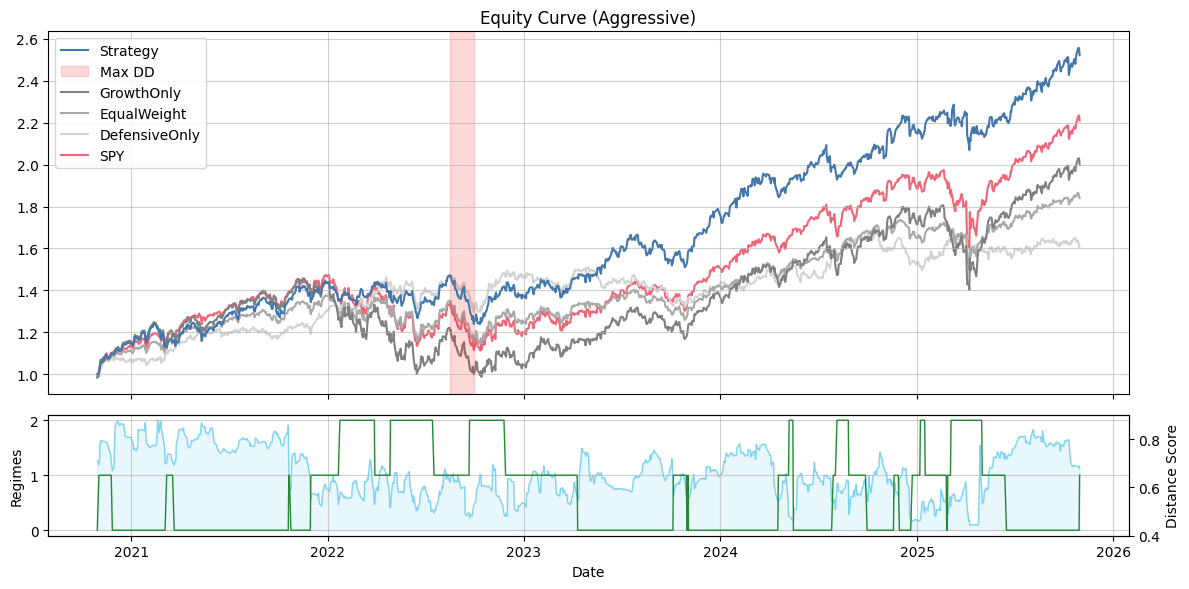

In [4]:
toolkit.plot_equity_curves("Aggressive")

In [5]:
toolkit.summary_table()

,cumulative_return,annual_return,annual_vol,sharpe,sortino,max_drawdown,hit_rate,avg_up_day,avg_down_day,skew,kurtosis
Strategy,152.2491%,20.4165%,14.5866%,1.399676,1.969269,-15.8518%,55.6972%,0.7005%,-0.7047%,-0.409681,1.328255
GrowthOnly,103.7758%,15.3657%,20.5021%,0.749472,1.053996,-32.3124%,53.6255%,0.9312%,-0.9365%,0.158421,5.536856
EqualWeight,85.8100%,13.2474%,13.7500%,0.963448,1.340707,-16.6554%,54.5817%,0.6182%,-0.6259%,0.008549,5.587800
DefensiveOnly,61.5923%,10.1159%,12.1861%,0.830121,1.208394,-12.5564%,53.8645%,0.5756%,-0.5827%,-0.213222,1.976309
SPY,123.3194%,17.5069%,17.1587%,1.020293,1.405235,-24.4964%,54.6614%,0.7634%,-0.7690%,0.289323,9.009576


In [6]:
toolkit.average_holding_period()

,avg,min,max,count
holding_periods,,,,
"G=1.0, D=0.0",56.67,1,149,12
"G=0.5, D=0.5",21.18,1,91,17
"G=0.0, D=1.0",30.71,6,54,7


In [7]:
toolkit.monthly_returns_table()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3352%,5.2636%,15.0902%
2021,-0.0053%,1.5622%,-0.3979%,5.4481%,-0.6927%,4.8842%,2.3941%,3.3276%,-5.1345%,7.4388%,-0.7233%,4.7865%,24.6295%
2022,-3.8640%,-0.7623%,3.9482%,-4.7971%,2.0365%,-2.6071%,5.7059%,-3.4409%,-9.8125%,10.2783%,5.0960%,-4.3417%,-4.2474%
2023,4.0089%,-2.1611%,3.6956%,1.8586%,2.0954%,6.7890%,3.5292%,-2.0382%,-5.3949%,-0.8585%,9.4102%,6.1168%,29.4207%
2024,0.9961%,6.3451%,2.3594%,-4.4599%,3.2198%,3.8782%,-0.0808%,0.5547%,1.9702%,-1.0225%,7.8529%,-1.7445%,21.0243%
2025,2.8093%,0.4867%,1.3952%,-3.9272%,2.2688%,3.7769%,2.1491%,1.8828%,3.4871%,1.9340%,NaN,NaN,17.2582%


In [8]:
toolkit.drawdown_table(top_n=5)

,start,trough,recovery,depth,time_to_trough,recovery_days,duration
rank,,,,,,,
37,2022-08-17,2022-09-30,2023-04-13,-15.8518%,44,195.0,239.0
35,2022-04-05,2022-06-17,2022-08-10,-12.1360%,73,54.0,127.0
81,2025-03-11,2025-04-08,2025-06-30,-9.5020%,28,83.0,111.0
51,2023-08-01,2023-10-27,2023-11-20,-9.4058%,87,24.0,111.0
16,2021-02-16,2021-03-08,2021-04-26,-9.0349%,20,49.0,69.0


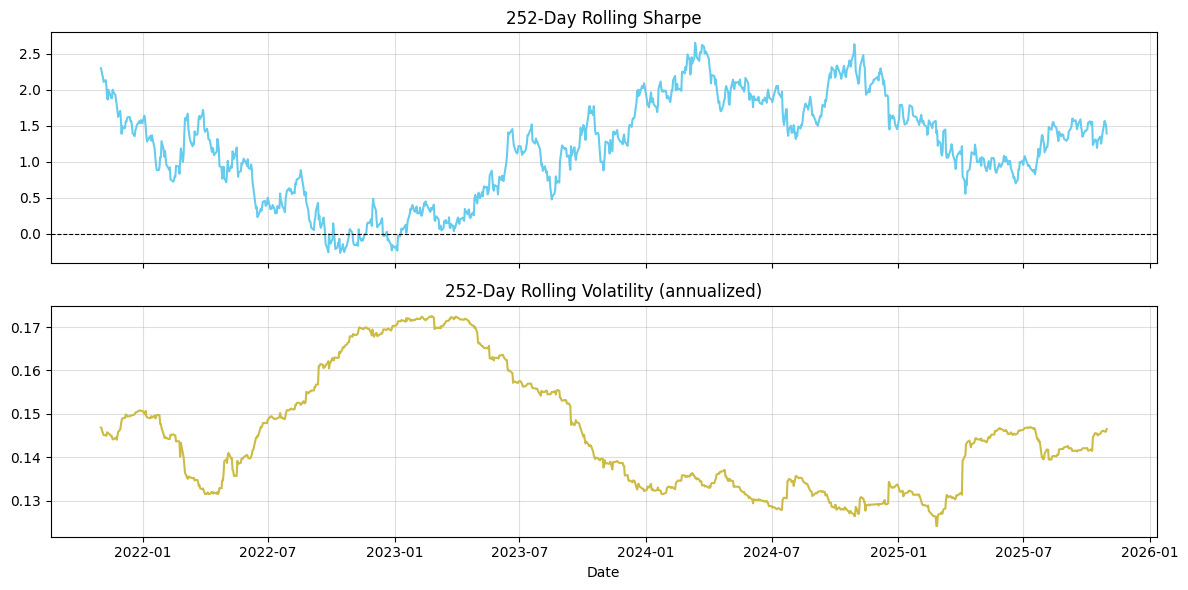

In [9]:
toolkit.plot_rolling_metrics(252)

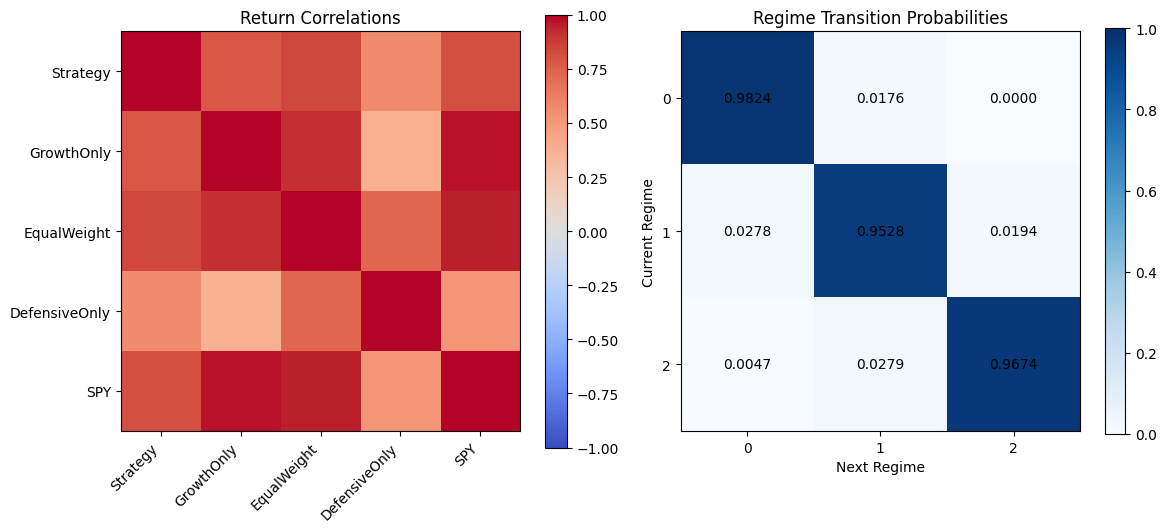

In [10]:
toolkit.plot_correlation_and_transitions()

### Conservative Strategy

In [11]:
conservative = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.0, "defensive": 1.0},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

toolkit = RegimePerformanceToolkit(conservative)
toolkit.show_basic_info()

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 680
# of points in cluster 1 : 361
# of points in cluster 2 : 215


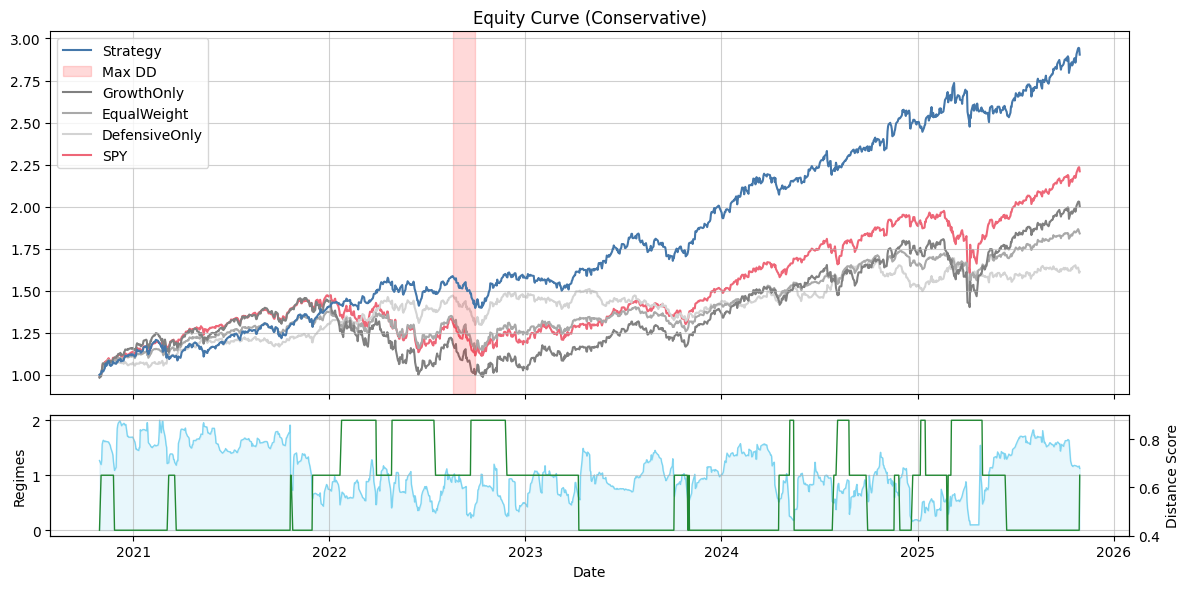

In [12]:
toolkit.plot_equity_curves("Conservative")

In [13]:
toolkit.summary_table()

,cumulative_return,annual_return,annual_vol,sharpe,sortino,max_drawdown,hit_rate,avg_up_day,avg_down_day,skew,kurtosis
Strategy,190.3905%,23.8698%,14.1898%,1.682177,2.371340,-11.9491%,55.9363%,0.6894%,-0.6732%,-0.388227,1.453502
GrowthOnly,103.7758%,15.3657%,20.5021%,0.749472,1.053996,-32.3124%,53.6255%,0.9312%,-0.9365%,0.158421,5.536856
EqualWeight,85.8100%,13.2474%,13.7500%,0.963448,1.340707,-16.6554%,54.5817%,0.6182%,-0.6259%,0.008549,5.587800
DefensiveOnly,61.5923%,10.1159%,12.1861%,0.830121,1.208394,-12.5564%,53.8645%,0.5756%,-0.5827%,-0.213222,1.976309
SPY,123.3194%,17.5069%,17.1587%,1.020293,1.405235,-24.4964%,54.6614%,0.7634%,-0.7690%,0.289323,9.009576


In [14]:
toolkit.average_holding_period()

,avg,min,max,count
holding_periods,,,,
"G=1.0, D=0.0",56.67,1,149,12
"G=0.0, D=1.0",52.27,1,340,11


In [15]:
toolkit.monthly_returns_table()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5713%,5.2636%,12.1808%
2021,-0.0053%,1.5622%,-2.1837%,5.4481%,-0.6927%,4.8842%,2.3941%,3.3276%,-5.1345%,7.4212%,-0.7233%,7.3305%,25.3457%
2022,2.3429%,-0.7623%,4.2637%,1.3044%,2.0365%,-2.6071%,3.4532%,-2.2100%,-7.8648%,10.2783%,4.2037%,-1.6254%,12.3308%
2023,-0.4425%,-2.7023%,3.0744%,3.3715%,2.0954%,6.7890%,3.5292%,-2.0382%,-5.3949%,1.2328%,8.8313%,6.1168%,26.2275%
2024,0.9961%,6.3451%,2.3594%,-3.9918%,1.9641%,3.8782%,-0.8058%,5.0867%,1.5280%,-1.0225%,8.1372%,-0.8532%,25.5567%
2025,1.1166%,4.4625%,1.9471%,-3.9272%,0.1591%,1.9700%,2.1491%,1.8828%,3.4871%,1.9340%,NaN,NaN,16.0009%


In [16]:
toolkit.drawdown_table(top_n=5)

,start,trough,recovery,depth,time_to_trough,recovery_days,duration
rank,,,,,,,
39,2022-08-22,2022-09-30,2022-11-22,-11.9491%,39,53.0,92.0
38,2022-04-21,2022-06-17,2022-08-16,-10.5788%,57,60.0,117.0
13,2021-02-16,2021-03-24,2021-06-24,-10.1808%,36,92.0,128.0
92,2025-03-11,2025-04-08,2025-08-12,-9.5020%,28,126.0,154.0
58,2023-08-01,2023-10-03,2023-11-14,-8.8286%,63,42.0,105.0


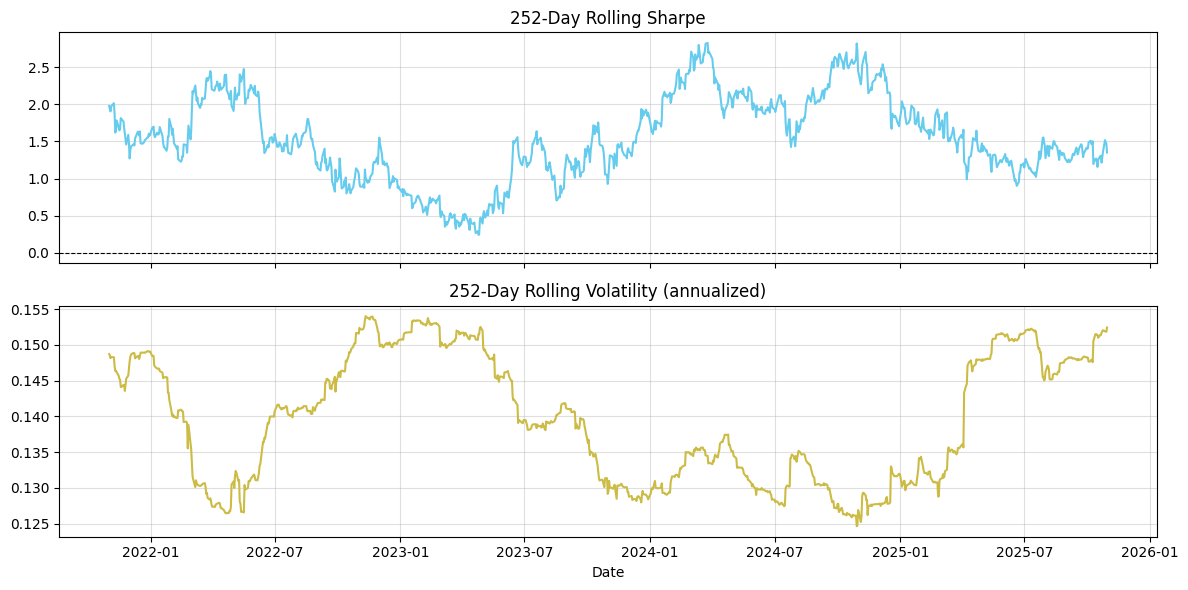

In [17]:
toolkit.plot_rolling_metrics(252)

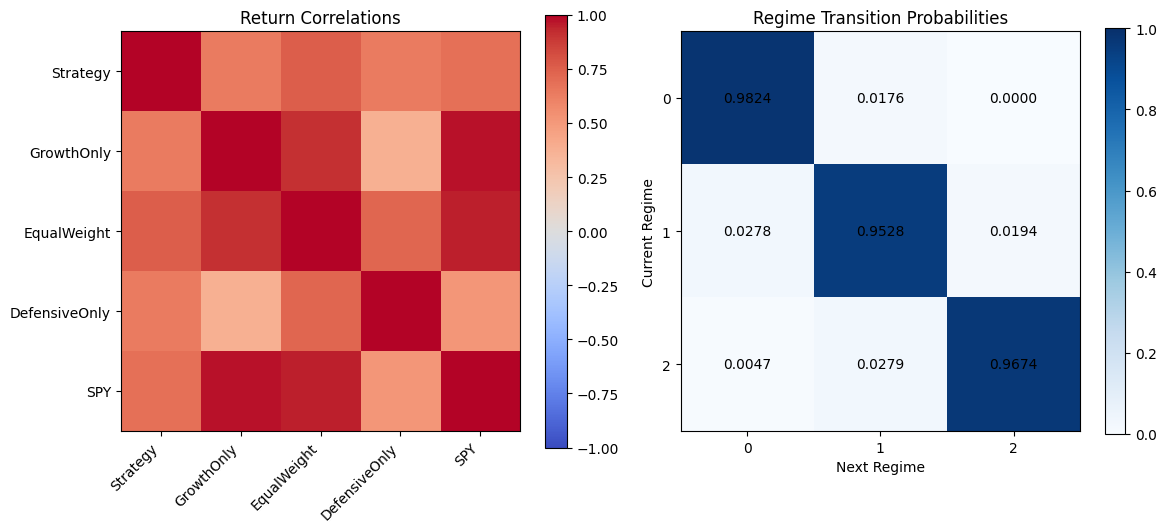

In [ ]:
toolkit.plot_correlation_and_transitions()

## Grid Search for Hyperparameter Tunning

In [19]:
df = RegimeRotationStrategy.grid_search_regimes(
    growth,
    defensive,
    start_date="2019-05-09",
    windows=(36, 72, 120, 240, 360, 480),
    steps=(6, 12, 24, 48),
    refits=(12, 24, 48, 96, 120),
)
df

Output()

start_date    end_date  duration  \
p window step refit_every burn_in                                     
2 360    12   48          700      2020-10-30  2025-10-30      1826   
              96          700      2020-10-30  2025-10-30      1826   
              12          700      2020-10-30  2025-10-30      1826   
              120         700      2020-10-30  2025-10-30      1826   
              24          700      2020-10-30  2025-10-30      1826   
...                                       ...         ...       ...   
         48   12          700      2025-02-05  2025-10-30       267   
              24          700      2025-02-05  2025-10-30       267   
              48          700      2025-02-05  2025-10-30       267   
              96          700      2025-02-05  2025-10-30       267   
              120         700      2025-02-05  2025-10-30       267   

                                   cumulative_return  annual_return  \
p window step refit_every burn_in                                     
2 360    12   48          700               1.897524       0.237940   
              96          700               1.903905       0.238487   
              12          700               1.879510       0.236392   
              120         700               1.860306       0.234733   
              24          700               1.866575       0.235276   
...                                              ...            ...   
         48   12          700              -0.081667      -0.109013   
              24          700              -0.081667      -0.109013   
              48          700              -0.081667      -0.109013   
              96          700              -0.081667      -0.109013   
              120         700              -0.081667      -0.109013   

                                   annual_volatility    sharpe  max_drawdown  
p window step refit_every burn_in                                             
2 360    12   48          700               0.140986  1.687692     -0.119491  
              96          700               0.141786  1.682022     -0.119491  
              12          700               0.141867  1.666294     -0.119491  
              120         700               0.141408  1.659969     -0.119491  
              24          700               0.141774  1.659508     -0.119491  
...                                              ...       ...           ...  
         48   12          700               0.179600 -0.606977     -0.246238  
              24          700               0.179600 -0.606977     -0.246238  
              48          700               0.179600 -0.606977     -0.246238  
              96          700               0.179600 -0.606977     -0.246238  
              120         700               0.179600 -0.606977     -0.246238  

[120 rows x 8 columns]